In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import random
from sklearn.manifold import TSNE
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
import cv2 # pip install opencv-python

In [2]:
df_raw = pd.read_csv("wdbc.csv", header=None)

### Split dataset and set aside 20% as test data

In [3]:

y = df_raw.iloc[:,1:2]
x = df_raw.iloc[:,2:]
x = (x - x.min()) / (x.max() - x.min()) #normalized x

#Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)


In [4]:
# Use training set and get the distribution of data
# Split training set to 2 classes to determine the minority class, where we will run Variational Autoencoder against

y_train = pd.get_dummies(y_train)
df_train = pd.concat([x_train, y_train], axis =1)
df_train_M_class = df_train.loc[df_train['1_M']==1]
df_train_B_class = df_train.loc[df_train['1_B']==1]

print("M: ", df_train_M_class.shape)
print("B: ", df_train_B_class.shape)

M:  (170, 32)
B:  (285, 32)


In [5]:
# as the M is the minority class, we will then generate data for M class to balance our set
# Get x and y from df_train_M_class
# df_train_M_class
x = df_train_M_class.iloc[:,:-2 ]
y = df_train_M_class.iloc[:,-2: ]
print(x)
print (y)

y = torch.Tensor(y.values)
x = torch.Tensor(x.values)


           2         3         4         5         6         7         8   \
408  0.521037  0.370308  0.511437  0.359788  0.460143  0.340531  0.281396   
4    0.629893  0.156578  0.630986  0.489290  0.430351  0.347893  0.463918   
517  0.610961  0.356781  0.599198  0.454083  0.461045  0.342372  0.330600   
535  0.642198  0.377071  0.649644  0.493955  0.469170  0.473959  0.488519   
236  0.768091  0.583700  0.758137  0.647508  0.383317  0.456475  0.456888   
..        ...       ...       ...       ...       ...       ...       ...   
252  0.603389  0.341901  0.600580  0.450689  0.483615  0.507699  0.566307   
468  0.502579  0.460602  0.519729  0.355037  0.363456  0.555242  0.500469   
254  0.590137  0.325330  0.571557  0.434995  0.459240  0.304951  0.323102   
129  0.606228  0.521136  0.598507  0.444751  0.441184  0.427949  0.596298   
72   0.483648  0.500845  0.486559  0.333362  0.491740  0.501871  0.396439   

           9         10        11  ...        22        23        24  \
408

In [6]:
#Generate Data for minority class M

class VariationalAutoencoder(nn.Module):
    def __init__(self, num_features=5, num_dim=30):
        super(VariationalAutoencoder, self).__init__()
        
        self.num_features = num_features
        self.num_dim = num_dim
        
        self.encoder_layer_1 = nn.Linear(in_features=self.num_dim, out_features=20)
        self.encoder_layer_2 = nn.Linear(in_features=20, out_features=(self.num_features * 2))
        
        self.decoder_layer_1 = nn.Linear(in_features=self.num_features, out_features=20)
        self.decoder_layer_2 = nn.Linear(in_features=20, out_features=self.num_dim)
        
        self.relu = nn.ReLU() # hidden layers
        self.sigmoid = nn.Sigmoid() # output layer
        
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std)  # `randn_like` as we need the same size
        sample = mu + (eps * std)    # sampling as if coming from the input space
        
        return sample
    
    def encode(self, x):
        # encoding
        #x = F.relu(self.encoder_layer_1(x))
        x = self.encoder_layer_1(x)
        x = self.relu(x)
        x = self.encoder_layer_2(x).view(-1, 2, self.num_features)
        
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        return z, mu, log_var
    
    def decode(self, z, mu, log_var):
        # decoding
        #x = F.relu(self.decoder_layer_1(z))
        x = self.decoder_layer_1(z)
        x = self.relu(x)
        
        #reconstruction = torch.sigmoid(self.decoder_layer_2(x))
        reconstruction = self.decoder_layer_2(x)
        reconstruction = self.sigmoid(reconstruction)
        
        return reconstruction, mu, log_var
    
    # Utility function to generate new data based on:
    # mu: The average that you want to have (should be the same size as num_features)
    # log_var: The variance that you want to have (should be the same size as num_features)
    def sample(self, mu, log_var):
        z = self.reparameterize(mu, log_var)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction
        
    
    def forward(self, x):
        
        z, mu, log_var = self.encode(x)
        reconstruction, mu, log_var = self.decode(z, mu, log_var)
        
        return reconstruction, mu, log_var

In [7]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class AutoencoderDataset(Dataset):
    def __init__(self, x):
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.x[index]

In [8]:
# The final loss is a combination of the reconstruction loss (first argument) and the loss from an assumed distribution (i.e. Normal / Gaussian distribution)
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
num_features = 5
model = VariationalAutoencoder(num_features=num_features)

In [10]:
learning_rate = 0.0001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 1

In [11]:
# Define the training process
# Each call of the train function == 1 Epoch
def train_fn(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        reconstruction, mu, logvar = model.forward(data)
        
        loss = loss_fn(reconstruction, targets)
        
        loss = final_loss(loss, mu, logvar)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

In [12]:
# use Dataloader for Autoencoder 
custom_dataset = AutoencoderDataset(x)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [13]:
epochs = 100
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    #state = { 'state_dict': model.state_dict() }

    #torch.save(state, "variational-autoencoder.pth")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 338.19it/s, loss=0.699]


Ave Loss: 0.7125665938152986
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 339.95it/s, loss=0.686]


Ave Loss: 0.6856842423186583
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 342.35it/s, loss=0.683]


Ave Loss: 0.6736495940124287
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 340.59it/s, loss=0.664]


Ave Loss: 0.6652476997936473
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 335.63it/s, loss=0.654]


Ave Loss: 0.6579313036273507
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 336.57it/s, loss=0.651]


Ave Loss: 0.6518333638415618
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 344.34it/s, loss=0.649]


Ave Loss: 0.645763729950961
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 336.04it/s, loss=0.647]


Ave Loss: 0.6406864579986123
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 340.61it/s, loss=0.641]


Ave Loss: 0.6347933348487406
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 340.74it/s, loss=0.649]


Ave Loss: 0.6299021489479962
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 342.00it/s, loss=0.627]


Ave Loss: 0.62497158295968
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 335.57it/s, loss=0.627]


Ave Loss: 0.6223468191483441
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 328.73it/s, loss=0.631]


Ave Loss: 0.6179151861106649
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 329.63it/s, loss=0.631]


Ave Loss: 0.6163096799569971
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 328.08it/s, loss=0.627]


Ave Loss: 0.6129812082823585
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 327.84it/s, loss=0.629]


Ave Loss: 0.6115578626885133
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 341.08it/s, loss=0.627]


Ave Loss: 0.6104439006132238
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 340.47it/s, loss=0.637]


Ave Loss: 0.6063750189893385
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 335.03it/s, loss=0.631]


Ave Loss: 0.6043788997565999
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 358.26it/s, loss=0.62]


Ave Loss: 0.6034029462758232
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 350.19it/s, loss=0.625]


Ave Loss: 0.6028510009541231
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 333.88it/s, loss=0.63]


Ave Loss: 0.6008291069199058
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 319.46it/s, loss=0.624]


Ave Loss: 0.6013868843807894
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 370.95it/s, loss=0.625]


Ave Loss: 0.6001990584766164
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 349.60it/s, loss=0.624]


Ave Loss: 0.5994983276900123
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 370.61it/s, loss=0.62]


Ave Loss: 0.598803183261086
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.74it/s, loss=0.622]


Ave Loss: 0.598743803360883
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.47it/s, loss=0.625]


Ave Loss: 0.5985524791128495
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 368.48it/s, loss=0.619]


Ave Loss: 0.5975724984617794
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 362.36it/s, loss=0.629]


Ave Loss: 0.5978824292912203
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.92it/s, loss=0.626]


Ave Loss: 0.5962323202806361
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.40it/s, loss=0.619]


Ave Loss: 0.5966570373843698
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 369.37it/s, loss=0.622]


Ave Loss: 0.5968206624774371
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 364.11it/s, loss=0.623]


Ave Loss: 0.5969354405122644
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 364.88it/s, loss=0.628]


Ave Loss: 0.5971234638901318
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 358.09it/s, loss=0.619]


Ave Loss: 0.5963671929696027
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 362.63it/s, loss=0.622]


Ave Loss: 0.5969648820512435
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 365.07it/s, loss=0.618]


Ave Loss: 0.598611124122844
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 368.67it/s, loss=0.624]


Ave Loss: 0.5952150527168723
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 370.28it/s, loss=0.628]


Ave Loss: 0.5958283783758388
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 368.03it/s, loss=0.64]


Ave Loss: 0.5959063961225397
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 356.47it/s, loss=0.62]


Ave Loss: 0.5961688006625456
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.47it/s, loss=0.619]


Ave Loss: 0.5963602868949666
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.15it/s, loss=0.619]


Ave Loss: 0.5948636316201266
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 367.84it/s, loss=0.622]


Ave Loss: 0.5946709964205237
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 371.01it/s, loss=0.623]


Ave Loss: 0.5948502323206734
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 370.74it/s, loss=0.623]


Ave Loss: 0.5946452899890787
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 372.84it/s, loss=0.621]


Ave Loss: 0.5952036433360156
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 371.99it/s, loss=0.623]


Ave Loss: 0.5952593750813429
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 369.64it/s, loss=0.623]


Ave Loss: 0.5944679004304549
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 373.34it/s, loss=0.62]


Ave Loss: 0.5949571769027149
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 370.08it/s, loss=0.62]


Ave Loss: 0.5945247208370882
Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 361.27it/s, loss=0.621]


Ave Loss: 0.595148820736829
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 366.20it/s, loss=0.62]


Ave Loss: 0.5958357384976218
Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 364.19it/s, loss=0.627]


Ave Loss: 0.5947200338630115
Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 329.47it/s, loss=0.623]


Ave Loss: 0.5951458790723015
Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 362.69it/s, loss=0.621]


Ave Loss: 0.5951115199748207
Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 341.23it/s, loss=0.622]


Ave Loss: 0.5943421837161569
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 365.53it/s, loss=0.621]


Ave Loss: 0.5941679290112327
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 346.66it/s, loss=0.619]


Ave Loss: 0.5944255078540129
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 368.65it/s, loss=0.628]


Ave Loss: 0.594950182648266
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 360.18it/s, loss=0.619]


Ave Loss: 0.5939581983229694
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 358.46it/s, loss=0.621]


Ave Loss: 0.5952879116815679
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 356.46it/s, loss=0.625]


Ave Loss: 0.5952775169821346
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 359.38it/s, loss=0.631]


Ave Loss: 0.5945330809144412
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 357.95it/s, loss=0.62]


Ave Loss: 0.5938600955640568
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 352.42it/s, loss=0.62]


Ave Loss: 0.5938806255074108
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 352.91it/s, loss=0.62]


Ave Loss: 0.5948080974466661
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 389.64it/s, loss=0.62]


Ave Loss: 0.5937701958067277
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 384.59it/s, loss=0.623]


Ave Loss: 0.5940178876414018
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 388.58it/s, loss=0.62]


Ave Loss: 0.5931746258455164
Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 397.26it/s, loss=0.618]


Ave Loss: 0.5936807611409356
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 380.77it/s, loss=0.621]


Ave Loss: 0.5935555712265127
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 386.84it/s, loss=0.62]


Ave Loss: 0.5930497127420762
Epoch: 74


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 401.53it/s, loss=0.62]


Ave Loss: 0.5940355216755586
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 360.67it/s, loss=0.622]


Ave Loss: 0.5935202297042398
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 354.30it/s, loss=0.619]


Ave Loss: 0.5937034592908972
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 385.02it/s, loss=0.622]


Ave Loss: 0.5930018978960374
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 315.71it/s, loss=0.62]


Ave Loss: 0.5932814887341331
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 322.18it/s, loss=0.621]


Ave Loss: 0.5938684870215023
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 414.03it/s, loss=0.62]


Ave Loss: 0.5932972583700629
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 390.27it/s, loss=0.62]


Ave Loss: 0.5939762885079665
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 401.14it/s, loss=0.626]


Ave Loss: 0.593899969143026
Epoch: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 401.50it/s, loss=0.62]


Ave Loss: 0.592691626794198
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 373.65it/s, loss=0.619]


Ave Loss: 0.5930742726606482
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 389.36it/s, loss=0.619]


Ave Loss: 0.594263326771119
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 382.68it/s, loss=0.634]


Ave Loss: 0.5933466124183991
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 384.63it/s, loss=0.622]


Ave Loss: 0.5931635470951304
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 369.32it/s, loss=0.625]


Ave Loss: 0.5933889534543543
Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 323.35it/s, loss=0.626]


Ave Loss: 0.5943068201051039
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 229.27it/s, loss=0.621]


Ave Loss: 0.5933850793277516
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 283.97it/s, loss=0.62]


Ave Loss: 0.5928279703154283
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 343.20it/s, loss=0.623]


Ave Loss: 0.5933144886704053
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 336.20it/s, loss=0.623]


Ave Loss: 0.5951442767592038
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 314.29it/s, loss=0.633]


Ave Loss: 0.5933642292723936
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 335.46it/s, loss=0.619]


Ave Loss: 0.5929908591158249
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 361.51it/s, loss=0.619]


Ave Loss: 0.5936577837256825
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 329.42it/s, loss=0.623]


Ave Loss: 0.5931864026714774
Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 330.69it/s, loss=0.621]


Ave Loss: 0.5933936105054968
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 346.67it/s, loss=0.627]

Ave Loss: 0.5930154912612018


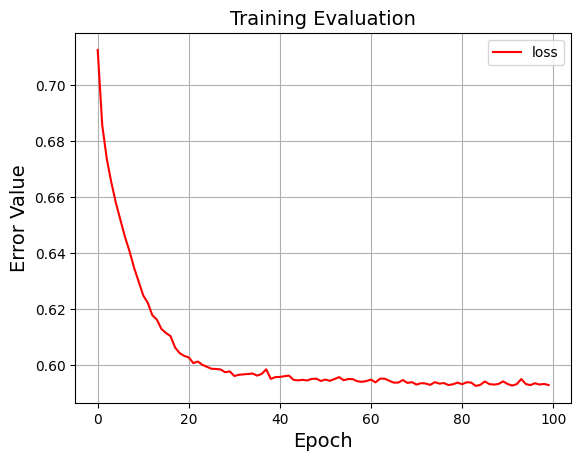

In [14]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [15]:
# Create a vector of zero tensors representing 0 average per num_feature (right in the middle of the dist)
sampled_mu = torch.Tensor([np.zeros(num_features)])

# Create a vector of zero tensors representing 0 standard deviations away from the mean to create variations
# Change this is you want to sample away from the mean to create "off-quality" data
sampled_logvar = torch.Tensor([np.zeros(num_features)])

print(sampled_logvar)

sampled_logvar.shape

tensor([[0., 0., 0., 0., 0.]])


C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_21864\563129376.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  sampled_mu = torch.Tensor([np.zeros(num_features)])


torch.Size([1, 5])

In [16]:
# Grab a reconstructed sample from the trained model
# NOTE: reconstruction returns as an array because it's possible to have multiple predictions later on
reconstruction = model.sample(sampled_mu, sampled_logvar)

In [17]:
reconstructed_data = reconstruction[0].detach().cpu().numpy()
#reconstructed_image = reconstructed_image.reshape(img_width, img_height)
#plt.imshow(reconstructed_image)
print(reconstructed_data)
print("shape: ", reconstructed_data.shape)


[0.5045796  0.40625972 0.5124905  0.37184975 0.44894874 0.38547853
 0.38029146 0.44893244 0.42658857 0.2772581  0.20721596 0.20698747
 0.19771853 0.13587265 0.16801175 0.24141836 0.11070979 0.28956977
 0.18078575 0.12651566 0.47467485 0.45800745 0.46267834 0.32169345
 0.47995162 0.33848137 0.36809015 0.6302718  0.34215933 0.2377326 ]
shape:  (30,)


In [18]:
#Generate 115 sampling
reconstructed_sample = []
added_y = []

for i in range(115):
    reconstruction = model.sample(sampled_mu, sampled_logvar)
    reconstructed_sample.append(reconstruction[0].detach().cpu().numpy())
    added_y.append([0,1])
    #print (reconstruction[0].detach().cpu().numpy())
    
    
# added_y    
# reconstructed_sample

In [19]:
x = df_train_M_class.iloc[:,:-2 ]
y = df_train_M_class.iloc[:,-2: ]

columns = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

df_reconstructed_sample = pd.DataFrame(reconstructed_sample) # Making the reconstructed output as dataframe

# synching the column names for each df
df_reconstructed_sample.columns = columns 
x.columns = columns

# ==================================
# Generate fabricated data set
# ==================================
fab_x = x.append(df_reconstructed_sample, ignore_index=True) # Append x + constructed data
print(fab_x)

# 285 columns

fab_y = pd.DataFrame(added_y, columns=["1_B", "1_M"])
fab_y = y.append(fab_y, ignore_index=True)
print(fab_y)



           1         2         3         4         5         6         7   \
0    0.521037  0.370308  0.511437  0.359788  0.460143  0.340531  0.281396   
1    0.629893  0.156578  0.630986  0.489290  0.430351  0.347893  0.463918   
2    0.610961  0.356781  0.599198  0.454083  0.461045  0.342372  0.330600   
3    0.642198  0.377071  0.649644  0.493955  0.469170  0.473959  0.488519   
4    0.768091  0.583700  0.758137  0.647508  0.383317  0.456475  0.456888   
..        ...       ...       ...       ...       ...       ...       ...   
280  0.506822  0.411350  0.508521  0.360883  0.450070  0.385615  0.400881   
281  0.516581  0.412507  0.510632  0.382232  0.460145  0.393218  0.383346   
282  0.489858  0.382952  0.509923  0.367668  0.449528  0.412573  0.370893   
283  0.498226  0.390104  0.508828  0.318839  0.431391  0.364324  0.368528   
284  0.499388  0.383676  0.515827  0.379360  0.463093  0.394021  0.373986   

           8         9         10  ...        21        22        23  \
0  

C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_21864\2982554781.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fab_x = x.append(df_reconstructed_sample, ignore_index=True) # Append x + constructed data
C:\Users\wmagampoadmin\AppData\Local\Temp\ipykernel_21864\2982554781.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fab_y = y.append(fab_y, ignore_index=True)


### Train Neural Network with 2 data sets:
1. 'Original training data set'
2. 'Fabricated training data set'

#### Fabricated Dataset

In [20]:
fab_y = torch.Tensor(fab_y.values)
fab_x = torch.Tensor(fab_x.values)

class NeuralNetwork(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 20) # input to first hidden layer                
        self.hidden_layer_2 = nn.Linear(20, 10)         
        self.hidden_layer_3 = nn.Linear(10, 5)         
        self.hidden_layer_4 = nn.Linear(5, 2)         
        
        self.output_layer = nn.Linear(2, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.hidden_layer_2(x)
        x = self.activation(x)
        
        x = self.hidden_layer_3(x)
        x = self.activation(x)
        
        x = self.hidden_layer_4(x)
        x = self.activation(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [21]:
model = NeuralNetwork(30, 2)

# Test structure of model
predictions = model.forward(fab_x)

In [22]:
learning_rate = 0.0001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
batch_size = 5

In [23]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset_2(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [24]:
def train_fn_2(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions = model.forward(data)
        
        loss = loss_fn(predictions, targets)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset_2(x=fab_x, y=fab_y)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 200
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_2(
        train_loader,
        model,
        optimizer,
        loss_fn,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    #state = { 'state_dict': model.state_dict() }

    #torch.save(state, "model.pth")

Epoch: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 315.63it/s, loss=0.238]


Ave Loss: 0.2392517262906359
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 314.33it/s, loss=0.235]


Ave Loss: 0.23640223631733343
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 274.29it/s, loss=0.232]


Ave Loss: 0.23363243095707475
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 235.07it/s, loss=0.23]


Ave Loss: 0.23093811566369576
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 268.09it/s, loss=0.227]


Ave Loss: 0.22831451657571292
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 285.24it/s, loss=0.225]


Ave Loss: 0.22575698034805164
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 310.80it/s, loss=0.222]


Ave Loss: 0.22326099402026126
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 237.30it/s, loss=0.22]


Ave Loss: 0.2208221227976314
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 223.48it/s, loss=0.217]


Ave Loss: 0.21843577869105757
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 244.75it/s, loss=0.215]


Ave Loss: 0.2160969334736205
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 270.50it/s, loss=0.213]


Ave Loss: 0.21379986849793217
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 285.33it/s, loss=0.21]


Ave Loss: 0.2115380282987628
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 310.27it/s, loss=0.208]


Ave Loss: 0.209303775116017
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 314.93it/s, loss=0.206]


Ave Loss: 0.20708845477355153
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 323.31it/s, loss=0.204]


Ave Loss: 0.20488243014143223
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 346.42it/s, loss=0.202]


Ave Loss: 0.20267553522921444
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 350.07it/s, loss=0.199]


Ave Loss: 0.20045772717710128
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 348.47it/s, loss=0.197]


Ave Loss: 0.19821983994099132
Epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 315.36it/s, loss=0.195]


Ave Loss: 0.19595426817735037
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 342.26it/s, loss=0.193]


Ave Loss: 0.1936552409540143
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 380.78it/s, loss=0.19]


Ave Loss: 0.191318716919213
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 373.83it/s, loss=0.188]


Ave Loss: 0.18894209464391074
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 372.10it/s, loss=0.185]


Ave Loss: 0.18652386126811044
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.06it/s, loss=0.183]


Ave Loss: 0.18406325866255843
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.80it/s, loss=0.18]


Ave Loss: 0.1815600729825204
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.08it/s, loss=0.178]


Ave Loss: 0.1790146652543754
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 384.36it/s, loss=0.175]


Ave Loss: 0.17642824822350553
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 397.03it/s, loss=0.173]


Ave Loss: 0.17380298464967495
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 371.78it/s, loss=0.17]


Ave Loss: 0.17114206259710746
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 384.25it/s, loss=0.167]


Ave Loss: 0.1684496222358001
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.31it/s, loss=0.164]


Ave Loss: 0.16573075270443632
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 387.63it/s, loss=0.162]


Ave Loss: 0.1629913122507564
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 390.44it/s, loss=0.159]


Ave Loss: 0.1602376754346647
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 380.91it/s, loss=0.156]


Ave Loss: 0.15747635327933127
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.72it/s, loss=0.153]


Ave Loss: 0.15471363172196506
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 385.89it/s, loss=0.151]


Ave Loss: 0.15195529241310923
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.43it/s, loss=0.148]


Ave Loss: 0.14920649899725327
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 400.81it/s, loss=0.145]


Ave Loss: 0.1464717027388121
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 389.55it/s, loss=0.142]


Ave Loss: 0.1437548098334095
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 409.65it/s, loss=0.14]


Ave Loss: 0.14105920206036485
Epoch: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.70it/s, loss=0.137]


Ave Loss: 0.13838784658072287
Epoch: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 385.47it/s, loss=0.134]


Ave Loss: 0.1357433476991821
Epoch: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 373.55it/s, loss=0.132]


Ave Loss: 0.13312796699373344
Epoch: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 368.07it/s, loss=0.129]


Ave Loss: 0.13054367324762178
Epoch: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.75it/s, loss=0.127]


Ave Loss: 0.12799217800299326
Epoch: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 347.98it/s, loss=0.124]


Ave Loss: 0.12547495712836584
Epoch: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 279.81it/s, loss=0.122]


Ave Loss: 0.12299323225753349
Epoch: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 276.58it/s, loss=0.119]


Ave Loss: 0.12054809535804548
Epoch: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 304.35it/s, loss=0.117]


Ave Loss: 0.11814040834443611
Epoch: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 272.23it/s, loss=0.115]


Ave Loss: 0.11577087405480836
Epoch: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 326.53it/s, loss=0.112]


Ave Loss: 0.1134400057949518
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 346.98it/s, loss=0.11]


Ave Loss: 0.11114816890473951
Epoch: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 355.43it/s, loss=0.108]


Ave Loss: 0.10889558781657302
Epoch: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 346.17it/s, loss=0.106]


Ave Loss: 0.10668235598948964
Epoch: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 346.81it/s, loss=0.103]


Ave Loss: 0.10450845786876846
Epoch: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 393.26it/s, loss=0.101]


Ave Loss: 0.10237378836200949
Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.39it/s, loss=0.0993]


Ave Loss: 0.10027817806653809
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 402.35it/s, loss=0.0972]


Ave Loss: 0.09822137418546174
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.00it/s, loss=0.0952]


Ave Loss: 0.09620306039588493
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 392.89it/s, loss=0.0933]


Ave Loss: 0.09422288508268825
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 405.46it/s, loss=0.0913]


Ave Loss: 0.0922804502280135
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.54it/s, loss=0.0895]


Ave Loss: 0.09037531167268753
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.26it/s, loss=0.0876]


Ave Loss: 0.08850700238294769
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.57it/s, loss=0.0858]


Ave Loss: 0.08667501415077009
Epoch: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 387.64it/s, loss=0.084]


Ave Loss: 0.08487880831224877
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 403.97it/s, loss=0.0823]


Ave Loss: 0.08311783940645687
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.56it/s, loss=0.0806]


Ave Loss: 0.08139151177908245
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.17it/s, loss=0.0789]


Ave Loss: 0.079699222325233
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.44it/s, loss=0.0772]


Ave Loss: 0.07804033656915028
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 400.48it/s, loss=0.0756]


Ave Loss: 0.07641418474285226
Epoch: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.17it/s, loss=0.074]


Ave Loss: 0.07482008479143444
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.16it/s, loss=0.0725]


Ave Loss: 0.0732573278640446
Epoch: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 367.97it/s, loss=0.071]


Ave Loss: 0.07172517282398123
Epoch: 73


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 371.51it/s, loss=0.0695]


Ave Loss: 0.0702228581434802
Epoch: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.86it/s, loss=0.068]


Ave Loss: 0.06874960059659523
Epoch: 75


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 371.00it/s, loss=0.0666]


Ave Loss: 0.06730460087981141
Epoch: 76


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 381.76it/s, loss=0.0652]


Ave Loss: 0.06588706491809142
Epoch: 77


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 370.77it/s, loss=0.0638]


Ave Loss: 0.06449619928995769
Epoch: 78


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.10it/s, loss=0.0625]


Ave Loss: 0.06313126455796392
Epoch: 79


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 395.97it/s, loss=0.0611]


Ave Loss: 0.0617915884706012
Epoch: 80


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.65it/s, loss=0.0598]


Ave Loss: 0.06047659380394116
Epoch: 81


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 381.02it/s, loss=0.0586]


Ave Loss: 0.05918582868680619
Epoch: 82


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 389.65it/s, loss=0.0573]


Ave Loss: 0.05791898561935676
Epoch: 83


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 378.49it/s, loss=0.0561]


Ave Loss: 0.056675867618698826
Epoch: 84


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.32it/s, loss=0.0549]


Ave Loss: 0.05545639586553239
Epoch: 85


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 385.07it/s, loss=0.0537]


Ave Loss: 0.054260564216396266
Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.79it/s, loss=0.0525]


Ave Loss: 0.05308840887849791
Epoch: 87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 397.60it/s, loss=0.0514]


Ave Loss: 0.05193994396872688
Epoch: 88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 362.21it/s, loss=0.0503]


Ave Loss: 0.05081516759176003
Epoch: 89


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 333.56it/s, loss=0.0492]


Ave Loss: 0.049714009947421256
Epoch: 90


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 337.66it/s, loss=0.0481]


Ave Loss: 0.048636325553321
Epoch: 91


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 350.16it/s, loss=0.0471]


Ave Loss: 0.04758189206844882
Epoch: 92


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 344.01it/s, loss=0.0461]


Ave Loss: 0.04655041441059949
Epoch: 93


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 382.08it/s, loss=0.0451]


Ave Loss: 0.04554152625956034
Epoch: 94


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 396.06it/s, loss=0.0441]


Ave Loss: 0.04455482168940075
Epoch: 95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 395.21it/s, loss=0.0431]


Ave Loss: 0.043589849221078975
Epoch: 96


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 393.18it/s, loss=0.0422]


Ave Loss: 0.042646124436144246
Epoch: 97


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 399.82it/s, loss=0.0413]


Ave Loss: 0.04172318173866523
Epoch: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 399.50it/s, loss=0.0404]


Ave Loss: 0.04082053370381657
Epoch: 99


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 406.30it/s, loss=0.0395]


Ave Loss: 0.03993773015967587
Epoch: 100


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.54it/s, loss=0.0387]


Ave Loss: 0.03907434655386105
Epoch: 101


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.96it/s, loss=0.0378]


Ave Loss: 0.03822998957414376
Epoch: 102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 395.18it/s, loss=0.037]


Ave Loss: 0.03740430100445162
Epoch: 103


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.92it/s, loss=0.0362]


Ave Loss: 0.03659695497991746
Epoch: 104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.56it/s, loss=0.0354]


Ave Loss: 0.03580765955542263
Epoch: 105


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 400.48it/s, loss=0.0347]


Ave Loss: 0.03503614219657162
Epoch: 106


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.38it/s, loss=0.0339]


Ave Loss: 0.03428213899595696
Epoch: 107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.21it/s, loss=0.0332]


Ave Loss: 0.03354539009824134
Epoch: 108


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 405.70it/s, loss=0.0325]


Ave Loss: 0.03282563590951133
Epoch: 109


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.15it/s, loss=0.0318]


Ave Loss: 0.03212260343787963
Epoch: 110


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.01it/s, loss=0.0311]


Ave Loss: 0.03143601067233504
Epoch: 111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 371.29it/s, loss=0.0304]


Ave Loss: 0.030765546060967864
Epoch: 112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 361.94it/s, loss=0.0298]


Ave Loss: 0.030110900437361317
Epoch: 113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.88it/s, loss=0.0292]


Ave Loss: 0.029471740191965773
Epoch: 114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.62it/s, loss=0.0285]


Ave Loss: 0.028847718088511835
Epoch: 115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 375.83it/s, loss=0.0279]


Ave Loss: 0.028238474473095777
Epoch: 116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 380.89it/s, loss=0.0274]


Ave Loss: 0.02764364665276126
Epoch: 117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 376.58it/s, loss=0.0268]


Ave Loss: 0.027062865170209033
Epoch: 118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 368.58it/s, loss=0.0262]


Ave Loss: 0.026495763084344696
Epoch: 119


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 381.02it/s, loss=0.0257]


Ave Loss: 0.02594197123197087
Epoch: 120


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 379.83it/s, loss=0.0251]


Ave Loss: 0.02540112489409614
Epoch: 121


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 382.62it/s, loss=0.0246]


Ave Loss: 0.024872866410173868
Epoch: 122


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.77it/s, loss=0.0241]


Ave Loss: 0.024356845374170103
Epoch: 123


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 385.14it/s, loss=0.0236]


Ave Loss: 0.02385271974561507
Epoch: 124


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 391.14it/s, loss=0.0231]


Ave Loss: 0.02336015679726475
Epoch: 125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 380.98it/s, loss=0.0226]


Ave Loss: 0.0228788304028281
Epoch: 126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 382.91it/s, loss=0.0222]


Ave Loss: 0.022408425546529002
Epoch: 127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 385.82it/s, loss=0.0217]


Ave Loss: 0.021948640316463354
Epoch: 128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.95it/s, loss=0.0213]


Ave Loss: 0.021499182506088624
Epoch: 129


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.94it/s, loss=0.0208]


Ave Loss: 0.021059768927986163
Epoch: 130


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 373.62it/s, loss=0.0204]


Ave Loss: 0.020630122342130595
Epoch: 131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 370.43it/s, loss=0.02]


Ave Loss: 0.02020998629169506
Epoch: 132


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 358.86it/s, loss=0.0196]


Ave Loss: 0.019799103208801204
Epoch: 133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 377.14it/s, loss=0.0192]


Ave Loss: 0.019397225721102012
Epoch: 134


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 403.81it/s, loss=0.0188]


Ave Loss: 0.01900411684784973
Epoch: 135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 399.96it/s, loss=0.0184]


Ave Loss: 0.0186195516337951
Epoch: 136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 402.84it/s, loss=0.0181]


Ave Loss: 0.018243310776980298
Epoch: 137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.75it/s, loss=0.0177]


Ave Loss: 0.017875179975179203
Epoch: 138


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.10it/s, loss=0.0173]


Ave Loss: 0.01751495234406831
Epoch: 139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.03it/s, loss=0.017]


Ave Loss: 0.01716243838401217
Epoch: 140


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 402.93it/s, loss=0.0167]


Ave Loss: 0.016817429870889897
Epoch: 141


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.53it/s, loss=0.0163]


Ave Loss: 0.016479760212333577
Epoch: 142


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 393.00it/s, loss=0.016]


Ave Loss: 0.016149236510197323
Epoch: 143


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.94it/s, loss=0.0157]


Ave Loss: 0.015825696714353143
Epoch: 144


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.13it/s, loss=0.0154]


Ave Loss: 0.015508961046866158
Epoch: 145


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 404.32it/s, loss=0.015]


Ave Loss: 0.015198882407786553
Epoch: 146


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.36it/s, loss=0.0147]


Ave Loss: 0.01489528350270631
Epoch: 147


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 399.66it/s, loss=0.0145]


Ave Loss: 0.014598032426938676
Epoch: 148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 392.46it/s, loss=0.0142]


Ave Loss: 0.014306964172998019
Epoch: 149


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.79it/s, loss=0.0139]


Ave Loss: 0.01402194474480654
Epoch: 150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.27it/s, loss=0.0136]


Ave Loss: 0.013742838839167043
Epoch: 151


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 347.64it/s, loss=0.0133]


Ave Loss: 0.013469495483788481
Epoch: 152


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 376.00it/s, loss=0.0131]


Ave Loss: 0.013201799897248285
Epoch: 153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 381.02it/s, loss=0.0128]


Ave Loss: 0.012939618982113245
Epoch: 154


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 373.52it/s, loss=0.0126]


Ave Loss: 0.012682816748948474
Epoch: 155


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 354.92it/s, loss=0.0123]


Ave Loss: 0.012431293431865541
Epoch: 156


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 378.40it/s, loss=0.0121]


Ave Loss: 0.012184920851467993
Epoch: 157


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 368.73it/s, loss=0.0118]


Ave Loss: 0.011943577821448184
Epoch: 158


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.03it/s, loss=0.0116]


Ave Loss: 0.011707162402831671
Epoch: 159


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 348.11it/s, loss=0.0114]


Ave Loss: 0.011475570892032824
Epoch: 160


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 369.41it/s, loss=0.0111]


Ave Loss: 0.011248684177796045
Epoch: 161


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 397.28it/s, loss=0.0109]


Ave Loss: 0.011026402183792047
Epoch: 162


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 390.21it/s, loss=0.0107]


Ave Loss: 0.010808637970241538
Epoch: 163


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 357.58it/s, loss=0.0105]


Ave Loss: 0.010595287065626237
Epoch: 164


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 387.39it/s, loss=0.0103]


Ave Loss: 0.01038624744927674
Epoch: 165


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 397.77it/s, loss=0.0101]


Ave Loss: 0.010181425433409842
Epoch: 166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 390.99it/s, loss=0.00988]


Ave Loss: 0.009980747655949048
Epoch: 167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 364.38it/s, loss=0.00969]


Ave Loss: 0.009784116556769923
Epoch: 168


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 359.33it/s, loss=0.0095]


Ave Loss: 0.009591439608157728
Epoch: 169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 388.27it/s, loss=0.00931]


Ave Loss: 0.00940263348125052
Epoch: 170


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.50it/s, loss=0.00913]


Ave Loss: 0.009217623523191401
Epoch: 171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 389.63it/s, loss=0.00895]


Ave Loss: 0.009036337123497537
Epoch: 172


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 402.46it/s, loss=0.00877]


Ave Loss: 0.008858681296962396
Epoch: 173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.67it/s, loss=0.0086]


Ave Loss: 0.008684578923541204
Epoch: 174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 372.41it/s, loss=0.00843]


Ave Loss: 0.008513958307734708
Epoch: 175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 402.35it/s, loss=0.00827]


Ave Loss: 0.008346759027948505
Epoch: 176


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 368.90it/s, loss=0.0081]


Ave Loss: 0.008182902330238568
Epoch: 177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 367.95it/s, loss=0.00794]


Ave Loss: 0.008022313970222808
Epoch: 178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 390.00it/s, loss=0.00779]


Ave Loss: 0.007864924809454303
Epoch: 179


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 398.31it/s, loss=0.00764]


Ave Loss: 0.0077106695246408905
Epoch: 180


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 394.33it/s, loss=0.00749]


Ave Loss: 0.007559497105447869
Epoch: 181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 401.85it/s, loss=0.00734]


Ave Loss: 0.007411334500239606
Epoch: 182


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 395.90it/s, loss=0.0072]


Ave Loss: 0.007266115282841942
Epoch: 183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 381.12it/s, loss=0.00705]


Ave Loss: 0.007123782953018682
Epoch: 184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 395.45it/s, loss=0.00692]


Ave Loss: 0.006984272685816936
Epoch: 185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 392.57it/s, loss=0.00678]


Ave Loss: 0.006847533863037825
Epoch: 186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 387.87it/s, loss=0.00665]


Ave Loss: 0.006713516773296553
Epoch: 187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 366.86it/s, loss=0.00652]


Ave Loss: 0.006582154116282861
Epoch: 188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 395.28it/s, loss=0.00639]


Ave Loss: 0.006453391417795629
Epoch: 189


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 385.89it/s, loss=0.00627]


Ave Loss: 0.0063271771364828994
Epoch: 190


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 386.20it/s, loss=0.00614]


Ave Loss: 0.006203460319196446
Epoch: 191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 400.41it/s, loss=0.00602]


Ave Loss: 0.006082196621910522
Epoch: 192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.57it/s, loss=0.00591]


Ave Loss: 0.005963335066968412
Epoch: 193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.57it/s, loss=0.00579]


Ave Loss: 0.005846818876371049
Epoch: 194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 392.29it/s, loss=0.00568]


Ave Loss: 0.0057326026113801885
Epoch: 195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 387.10it/s, loss=0.00557]


Ave Loss: 0.005620641666546203
Epoch: 196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 383.50it/s, loss=0.00546]


Ave Loss: 0.005510886820654075
Epoch: 197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 393.00it/s, loss=0.00535]


Ave Loss: 0.005403309153687013
Epoch: 198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 397.86it/s, loss=0.00525]


Ave Loss: 0.005297847296389048
Epoch: 199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 393.32it/s, loss=0.00514]

Ave Loss: 0.005194466683621469


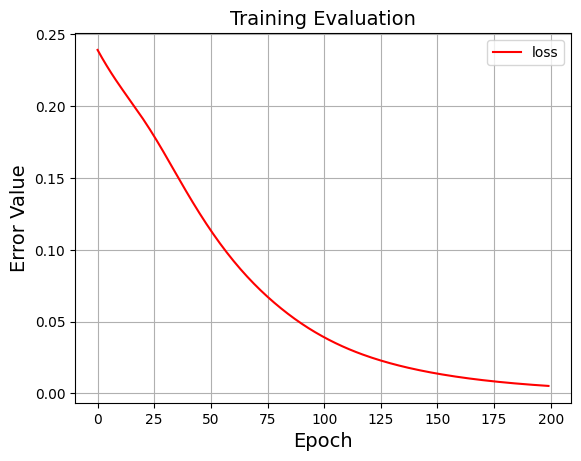

In [25]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [26]:

y_test = pd.get_dummies(y_test)
y_test = torch.Tensor(y_test.values)
x_test = torch.Tensor(x_test.values)

model = NeuralNetwork(30, 2)

predictions_1 = model.forward(x_test)
preds_1 = predictions_1.detach().cpu().numpy()

ohe = []
for i in preds_1:
       if i[0] > i[1]:
         ohe.append([1,0])
       else:
        ohe.append([0,1])
#preds
ohe

acc = accuracy_score(ohe, y_test)
cl_report = classification_report(ohe, y_test)
print("acc: ", acc)
print("cl report: ", cl_report)

acc:  0.3684210526315789
cl report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.37      0.54       114

   micro avg       0.37      0.37      0.37       114
   macro avg       0.50      0.18      0.27       114
weighted avg       1.00      0.37      0.54       114
 samples avg       0.37      0.37      0.37       114



D:\Python10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network - original training set

In [29]:
y_train = torch.Tensor(y_train.values)
x_train = torch.Tensor(x_train.values)

class NeuralNetwork_orig(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.hidden_layer_1 = nn.Linear(self.in_dim, 20) # input to first hidden layer                
        self.hidden_layer_2 = nn.Linear(20, 10)         
        self.hidden_layer_3 = nn.Linear(10, 5)         
        self.hidden_layer_4 = nn.Linear(5, 2)         
        
        self.output_layer = nn.Linear(2, self.out_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden_layer_1(x)
        x = self.activation(x)
        
        x = self.hidden_layer_2(x)
        x = self.activation(x)
        
        x = self.hidden_layer_3(x)
        x = self.activation(x)
        
        x = self.hidden_layer_4(x)
        x = self.activation(x)
        
        y = self.output_layer(x)
        y = self.activation(y)
        
        return y

In [30]:
model_2 = NeuralNetwork_orig(30, 2)

# Test structure of model
predictions = model_2.forward(x_train)

In [31]:
learning_rate = 0.001

loss_fn_2 = nn.MSELoss()
optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate)
batch_size = 5

In [32]:
# Custom dataset to treat how the model picks an x, y combination from the dataset
class MyCustomDataset_orig(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    # Requires you to return data as a pair of _x, _y
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [33]:
def train_fn_orig(loader, model, optimizer, loss_fn, batch_size):
    loop = tqdm(loader)
    
    count = 0
    ave_loss = 0.00
    
    # Loop per batch
    for batch_idx, (data, targets) in enumerate(loop):
        predictions_2 = model_2.forward(data)
        
        loss = loss_fn_2(predictions_2, targets)
        
        optimizer_2.zero_grad()
        
        loss.backward()
        
        optimizer_2.step()
        
        loop.set_postfix(loss=loss.item())
        
        ave_loss += loss.item()
        count += 1
        
    ave_loss = ave_loss / count
    
    return ave_loss

# Dataloader is in charge of:
# - partitioning data into batches
# - optionally shuffling the data
# - run the optimizer against a partition defined by this loader
custom_dataset = MyCustomDataset_orig(x=x_train, y=y_train)

train_loader = DataLoader(
    custom_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

epochs = 200
losses = []

for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    ave_loss = train_fn_orig(
        train_loader,
        model_2,
        optimizer_2,
        loss_fn_2,
        batch_size
    )
    
    losses.append(ave_loss)
    
    print("Ave Loss: {}".format(ave_loss))
    
    #state = { 'state_dict': model.state_dict() }

    #torch.save(state, "model.pth")

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 357.43it/s, loss=0.27]


Ave Loss: 0.27754718622008523
Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 368.51it/s, loss=0.262]


Ave Loss: 0.26688999494353494
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 349.63it/s, loss=0.255]


Ave Loss: 0.25778630948983705
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 358.00it/s, loss=0.249]


Ave Loss: 0.250251721058573
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 327.77it/s, loss=0.245]


Ave Loss: 0.24447767714877705
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 361.83it/s, loss=0.242]


Ave Loss: 0.24037379501285133
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 373.29it/s, loss=0.24]


Ave Loss: 0.2375834196150958
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 379.18it/s, loss=0.239]


Ave Loss: 0.2355784569140319
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 450.83it/s, loss=0.237]


Ave Loss: 0.2338987960592731
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 473.30it/s, loss=0.235]


Ave Loss: 0.2321927752141114
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 452.40it/s, loss=0.233]


Ave Loss: 0.2302181242586492
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 365.59it/s, loss=0.23]


Ave Loss: 0.22780626095258272
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 362.69it/s, loss=0.226]


Ave Loss: 0.22479654864950493
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 351.21it/s, loss=0.221]


Ave Loss: 0.22100568079686428
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 374.75it/s, loss=0.214]


Ave Loss: 0.2162456594325684
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 343.70it/s, loss=0.207]


Ave Loss: 0.21036412902585752
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 367.05it/s, loss=0.198]


Ave Loss: 0.2032900301145983
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 354.26it/s, loss=0.188]


Ave Loss: 0.19507312291598583
Epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 349.75it/s, loss=0.176]


Ave Loss: 0.18589342614779106
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 413.38it/s, loss=0.165]


Ave Loss: 0.1760246958378907
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 417.40it/s, loss=0.153]


Ave Loss: 0.1657748452418453
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 421.52it/s, loss=0.141]


Ave Loss: 0.15543590355050432
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 410.92it/s, loss=0.13]


Ave Loss: 0.1452573333959003
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.07it/s, loss=0.119]


Ave Loss: 0.13543539870898802
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 409.83it/s, loss=0.109]


Ave Loss: 0.12610875307531147
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 427.83it/s, loss=0.1]


Ave Loss: 0.11736031228696907
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 423.77it/s, loss=0.0917]


Ave Loss: 0.10922709099211536
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 419.07it/s, loss=0.084]


Ave Loss: 0.10171337171897783
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 394.46it/s, loss=0.0769]


Ave Loss: 0.09480189871820775
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 396.70it/s, loss=0.0706]


Ave Loss: 0.0884620671743875
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 411.97it/s, loss=0.0648]


Ave Loss: 0.08265556992737802
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 404.08it/s, loss=0.0596]


Ave Loss: 0.07734059182169674
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 390.96it/s, loss=0.0548]


Ave Loss: 0.07247498328541661
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 412.78it/s, loss=0.0505]


Ave Loss: 0.06801855175213499
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 421.46it/s, loss=0.0467]


Ave Loss: 0.06393470946740318
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 417.46it/s, loss=0.0431]


Ave Loss: 0.060191213470566406
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.47it/s, loss=0.0399]


Ave Loss: 0.05675981259280509
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 414.02it/s, loss=0.037]


Ave Loss: 0.0536151068428388
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 403.78it/s, loss=0.0344]


Ave Loss: 0.0507333301376183
Epoch: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 416.47it/s, loss=0.032]


Ave Loss: 0.0480918009857555
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 417.82it/s, loss=0.0297]


Ave Loss: 0.04566897079348564
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 416.69it/s, loss=0.0277]


Ave Loss: 0.04344475236567822
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 419.14it/s, loss=0.0259]


Ave Loss: 0.0414007501164963
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 399.14it/s, loss=0.0242]


Ave Loss: 0.03952024960992755
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 399.77it/s, loss=0.0226]


Ave Loss: 0.0377880595010388
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 415.01it/s, loss=0.0212]


Ave Loss: 0.036190337040922144
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 420.67it/s, loss=0.0199]


Ave Loss: 0.03471425361931324
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 421.02it/s, loss=0.0187]


Ave Loss: 0.03334788076456759
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 420.62it/s, loss=0.0176]


Ave Loss: 0.03208020866776888
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 418.37it/s, loss=0.0165]


Ave Loss: 0.030900971063382025
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.07it/s, loss=0.0156]


Ave Loss: 0.02980079718834751
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 407.79it/s, loss=0.0147]


Ave Loss: 0.02877102655123223
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 413.71it/s, loss=0.0138]


Ave Loss: 0.027803613773577814
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 406.41it/s, loss=0.0131]


Ave Loss: 0.026890818991667623
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 362.59it/s, loss=0.0124]


Ave Loss: 0.026024605874176862
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 432.83it/s, loss=0.0117]


Ave Loss: 0.02519580673753888
Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 445.36it/s, loss=0.0111]


Ave Loss: 0.024393403401168492
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 435.11it/s, loss=0.0105]


Ave Loss: 0.023605093390650148
Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 445.86it/s, loss=0.00994]


Ave Loss: 0.022821624251594255
Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 433.56it/s, loss=0.00943]


Ave Loss: 0.022044887582024376
Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 433.11it/s, loss=0.00895]


Ave Loss: 0.02129173698415468
Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 436.49it/s, loss=0.00849]


Ave Loss: 0.020584534009365916
Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 432.54it/s, loss=0.00806]


Ave Loss: 0.019936826719728473
Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 445.68it/s, loss=0.00766]


Ave Loss: 0.01934951206587337
Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 441.43it/s, loss=0.00729]


Ave Loss: 0.018816462242054743
Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 428.51it/s, loss=0.00693]


Ave Loss: 0.018330121162132576
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.69it/s, loss=0.0066]


Ave Loss: 0.01788375571697623
Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 417.88it/s, loss=0.00628]


Ave Loss: 0.017471845092886424
Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 417.74it/s, loss=0.00599]


Ave Loss: 0.01708987901232891
Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 419.63it/s, loss=0.00571]


Ave Loss: 0.016734169494196937
Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 419.63it/s, loss=0.00545]


Ave Loss: 0.016401653653931814
Epoch: 71


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 421.66it/s, loss=0.0052]


Ave Loss: 0.016089738822531896
Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 424.34it/s, loss=0.00497]


Ave Loss: 0.01579621640944874
Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 377.00it/s, loss=0.00475]


Ave Loss: 0.015519219138506022
Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 387.27it/s, loss=0.00454]


Ave Loss: 0.015257093175263196
Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 416.45it/s, loss=0.00434]


Ave Loss: 0.015008434090394896
Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 414.53it/s, loss=0.00416]


Ave Loss: 0.014771970482747797
Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 432.78it/s, loss=0.00398]


Ave Loss: 0.014546618520558536
Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 418.11it/s, loss=0.00382]


Ave Loss: 0.014331384930391234
Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 398.08it/s, loss=0.00366]


Ave Loss: 0.014125404406113776
Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 315.85it/s, loss=0.00351]


Ave Loss: 0.013927899633667298
Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 348.47it/s, loss=0.00337]


Ave Loss: 0.01373817125376273
Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 395.56it/s, loss=0.00324]


Ave Loss: 0.013555598767617574
Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 439.34it/s, loss=0.00311]


Ave Loss: 0.013379618960463411
Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 439.29it/s, loss=0.00299]


Ave Loss: 0.013209733449352475
Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 426.91it/s, loss=0.00287]


Ave Loss: 0.013045498134138493
Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.84it/s, loss=0.00276]


Ave Loss: 0.012886515693165936
Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 425.78it/s, loss=0.00266]


Ave Loss: 0.012732442870101595
Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 430.96it/s, loss=0.00256]


Ave Loss: 0.012582973310989993
Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 429.71it/s, loss=0.00247]


Ave Loss: 0.012437832447096378
Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 439.93it/s, loss=0.00238]


Ave Loss: 0.012296777730295947
Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 432.97it/s, loss=0.00229]


Ave Loss: 0.012159624955729469
Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 372.35it/s, loss=0.00221]


Ave Loss: 0.012026197755463666
Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 340.80it/s, loss=0.00213]


Ave Loss: 0.011896346475683398
Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 410.48it/s, loss=0.00206]


Ave Loss: 0.011769944865891075
Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.78it/s, loss=0.00199]


Ave Loss: 0.011646884483295483
Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 391.95it/s, loss=0.00192]


Ave Loss: 0.01152708283164999
Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 376.94it/s, loss=0.00186]


Ave Loss: 0.011410446984662705
Epoch: 98


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 379.58it/s, loss=0.0018]


Ave Loss: 0.011296901543583761
Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 401.61it/s, loss=0.00174]


Ave Loss: 0.011186400088123404
Epoch: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 419.08it/s, loss=0.00168]


Ave Loss: 0.011078859763834012
Epoch: 101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 422.98it/s, loss=0.00163]


Ave Loss: 0.010974223245764254
Epoch: 102


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 431.84it/s, loss=0.00158]


Ave Loss: 0.010872437526564022
Epoch: 103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 420.66it/s, loss=0.00153]


Ave Loss: 0.010773425319252515
Epoch: 104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 435.00it/s, loss=0.00148]


Ave Loss: 0.010677134725623406
Epoch: 105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 333.89it/s, loss=0.00144]


Ave Loss: 0.01058348870431943
Epoch: 106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 414.74it/s, loss=0.00139]


Ave Loss: 0.010492426331748593
Epoch: 107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 416.64it/s, loss=0.00135]


Ave Loss: 0.010403874437682904
Epoch: 108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 396.35it/s, loss=0.00131]


Ave Loss: 0.010317755626401977
Epoch: 109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 428.39it/s, loss=0.00127]


Ave Loss: 0.010234005485692031
Epoch: 110


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 423.19it/s, loss=0.00124]


Ave Loss: 0.010152529990351707
Epoch: 111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 434.49it/s, loss=0.0012]


Ave Loss: 0.010073275321961514
Epoch: 112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 350.16it/s, loss=0.00117]


Ave Loss: 0.009996158489189878
Epoch: 113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 336.50it/s, loss=0.00113]


Ave Loss: 0.009921119312991153
Epoch: 114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 412.87it/s, loss=0.0011]


Ave Loss: 0.009848087518168921
Epoch: 115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 391.60it/s, loss=0.00107]


Ave Loss: 0.00977698467405779
Epoch: 116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 409.36it/s, loss=0.00104]


Ave Loss: 0.00970776302223145
Epoch: 117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 347.07it/s, loss=0.00101]


Ave Loss: 0.009640362849305537
Epoch: 118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.23it/s, loss=0.000988]


Ave Loss: 0.009574721880758611
Epoch: 119


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 382.63it/s, loss=0.000962]


Ave Loss: 0.009510793105269281
Epoch: 120


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 410.84it/s, loss=0.000937]


Ave Loss: 0.00944853180336285
Epoch: 121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 413.57it/s, loss=0.000913]


Ave Loss: 0.00938788659558478
Epoch: 122


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 413.20it/s, loss=0.000889]


Ave Loss: 0.009328812764379309
Epoch: 123


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 406.96it/s, loss=0.000867]


Ave Loss: 0.009271285997493868
Epoch: 124


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 414.97it/s, loss=0.000845]


Ave Loss: 0.009215251403824927
Epoch: 125


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 361.76it/s, loss=0.000824]


Ave Loss: 0.00916067327329234
Epoch: 126


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 345.08it/s, loss=0.000803]


Ave Loss: 0.009107522071584814
Epoch: 127


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 343.31it/s, loss=0.000784]


Ave Loss: 0.00905575505892777
Epoch: 128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 334.28it/s, loss=0.000765]


Ave Loss: 0.00900533500032827
Epoch: 129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 333.92it/s, loss=0.000746]


Ave Loss: 0.008956233283842575
Epoch: 130


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 252.57it/s, loss=0.000728]


Ave Loss: 0.008908412644414457
Epoch: 131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 327.25it/s, loss=0.000711]


Ave Loss: 0.008861831157816226
Epoch: 132


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 303.09it/s, loss=0.000695]


Ave Loss: 0.008816457105350199
Epoch: 133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 295.08it/s, loss=0.000678]


Ave Loss: 0.008772257058548607
Epoch: 134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 388.38it/s, loss=0.000663]


Ave Loss: 0.008729196862307387
Epoch: 135


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 348.08it/s, loss=0.000648]


Ave Loss: 0.008687236359736953
Epoch: 136


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 288.47it/s, loss=0.000633]


Ave Loss: 0.008646345137654303
Epoch: 137


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 325.44it/s, loss=0.000619]


Ave Loss: 0.008606492526378932
Epoch: 138


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 361.63it/s, loss=0.000605]


Ave Loss: 0.008567643935208792
Epoch: 139


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 394.63it/s, loss=0.000591]


Ave Loss: 0.00852977201613792
Epoch: 140


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 410.37it/s, loss=0.000578]


Ave Loss: 0.008492845423381449
Epoch: 141


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 431.52it/s, loss=0.000566]


Ave Loss: 0.008456835319201083
Epoch: 142


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 435.91it/s, loss=0.000553]


Ave Loss: 0.008421722634511252
Epoch: 143


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 415.73it/s, loss=0.000541]


Ave Loss: 0.008387477300897405
Epoch: 144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.10it/s, loss=0.00053]


Ave Loss: 0.008354080910026863
Epoch: 145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 379.42it/s, loss=0.000518]


Ave Loss: 0.008321513441982321
Epoch: 146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 429.10it/s, loss=0.000507]


Ave Loss: 0.008289750038254698
Epoch: 147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 433.61it/s, loss=0.000497]


Ave Loss: 0.008258778326837654
Epoch: 148


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 412.58it/s, loss=0.000486]


Ave Loss: 0.008228578251993775
Epoch: 149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 383.21it/s, loss=0.000476]


Ave Loss: 0.008199135693567958
Epoch: 150


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 431.03it/s, loss=0.000467]


Ave Loss: 0.00817044220025559
Epoch: 151


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 401.74it/s, loss=0.000457]


Ave Loss: 0.008142480591202032
Epoch: 152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 340.56it/s, loss=0.000448]


Ave Loss: 0.00811524450482166
Epoch: 153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 293.22it/s, loss=0.000439]


Ave Loss: 0.008088722822171953
Epoch: 154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 295.38it/s, loss=0.00043]


Ave Loss: 0.008062906538655695
Epoch: 155


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 347.57it/s, loss=0.000421]


Ave Loss: 0.008037788225120383
Epoch: 156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 337.77it/s, loss=0.000413]


Ave Loss: 0.008013360565310794
Epoch: 157


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 403.34it/s, loss=0.000405]


Ave Loss: 0.007989622237721131
Epoch: 158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.76it/s, loss=0.000397]


Ave Loss: 0.00796656543293016
Epoch: 159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.64it/s, loss=0.000389]


Ave Loss: 0.007944191445578607
Epoch: 160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 404.89it/s, loss=0.000382]


Ave Loss: 0.007922493583064752
Epoch: 161


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 405.03it/s, loss=0.000374]


Ave Loss: 0.007901476060007033
Epoch: 162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 411.10it/s, loss=0.000367]


Ave Loss: 0.007881135167106269
Epoch: 163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 404.39it/s, loss=0.00036]


Ave Loss: 0.007861475587840406
Epoch: 164


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.28it/s, loss=0.000354]


Ave Loss: 0.00784249753840933
Epoch: 165


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 387.82it/s, loss=0.000347]


Ave Loss: 0.00782420559131264
Epoch: 166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 422.13it/s, loss=0.00034]


Ave Loss: 0.007806604735298686
Epoch: 167


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 413.34it/s, loss=0.000334]


Ave Loss: 0.0077897032281795805
Epoch: 168


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 398.47it/s, loss=0.000328]


Ave Loss: 0.007773511724036115
Epoch: 169


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 340.78it/s, loss=0.000322]


Ave Loss: 0.007758037707350053
Epoch: 170


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 410.32it/s, loss=0.000316]


Ave Loss: 0.007743292510225489
Epoch: 171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 412.70it/s, loss=0.00031]


Ave Loss: 0.0077292911412839135
Epoch: 172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 411.98it/s, loss=0.000305]


Ave Loss: 0.0077160492766159845
Epoch: 173


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 395.65it/s, loss=0.000299]


Ave Loss: 0.007703590833493713
Epoch: 174


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.22it/s, loss=0.000294]


Ave Loss: 0.007691934314757268
Epoch: 175


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 384.65it/s, loss=0.000289]


Ave Loss: 0.007681106716767977
Epoch: 176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 394.97it/s, loss=0.000284]


Ave Loss: 0.007671135203474058
Epoch: 177


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 381.23it/s, loss=0.000279]


Ave Loss: 0.007662052998177267
Epoch: 178


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 391.89it/s, loss=0.000274]


Ave Loss: 0.007653901260410139
Epoch: 179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 405.23it/s, loss=0.000269]


Ave Loss: 0.007646717762946826
Epoch: 180


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 409.01it/s, loss=0.000265]


Ave Loss: 0.007640551407898234
Epoch: 181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 408.25it/s, loss=0.00026]


Ave Loss: 0.007635456405146365
Epoch: 182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 405.34it/s, loss=0.000256]


Ave Loss: 0.007631493864899532
Epoch: 183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 410.98it/s, loss=0.000252]


Ave Loss: 0.00762873376475949
Epoch: 184


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 409.28it/s, loss=0.000248]


Ave Loss: 0.007627258126996201
Epoch: 185


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 401.67it/s, loss=0.000244]


Ave Loss: 0.00762715170931987
Epoch: 186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 411.10it/s, loss=0.00024]


Ave Loss: 0.007628512722766283
Epoch: 187


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 392.04it/s, loss=0.000236]


Ave Loss: 0.007631455262986032
Epoch: 188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 401.46it/s, loss=0.000232]


Ave Loss: 0.0076361063702779074
Epoch: 189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 412.00it/s, loss=0.000228]


Ave Loss: 0.0076426196548189705
Epoch: 190


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 400.58it/s, loss=0.000225]


Ave Loss: 0.007651158874988131
Epoch: 191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 409.78it/s, loss=0.000221]


Ave Loss: 0.007661917780021943
Epoch: 192


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 411.66it/s, loss=0.000218]


Ave Loss: 0.007675110243576205
Epoch: 193


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 407.97it/s, loss=0.000215]


Ave Loss: 0.007690996424151728
Epoch: 194


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 376.83it/s, loss=0.000211]


Ave Loss: 0.0077098667663829095
Epoch: 195


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 389.93it/s, loss=0.000208]


Ave Loss: 0.007732058624122266
Epoch: 196


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 404.61it/s, loss=0.000205]


Ave Loss: 0.00775796163481453
Epoch: 197


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 409.52it/s, loss=0.000202]


Ave Loss: 0.007788038136473356
Epoch: 198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 401.46it/s, loss=0.0002]


Ave Loss: 0.007822809476807718
Epoch: 199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 91/91 [00:00<00:00, 407.96it/s, loss=0.000197]

Ave Loss: 0.007862898759872674


In [ ]:
plt.plot(losses, label='loss', color='red')
plt.title('Training Evaluation', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Error Value', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#y_test = torch.Tensor(y_test.values)
#x_test = torch.Tensor(x_test.values)

model_2 = NeuralNetwork_orig(30, 2)

predictions_2 = model_2.forward(x_test)
preds_2 = predictions_2.detach().cpu().numpy()

ohe_2 = []
for i in preds_2:
       if i[0] > i[1]:
         ohe_2.append([1,0])
       else:
        ohe_2.append([0,1])


acc = accuracy_score(ohe_2, y_test)
cl_report = classification_report(ohe_2, y_test)
print("acc: ", acc)
print("cl report: ", cl_report)